In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import pandas as pd
import random
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

2024-09-28 04:57:45.674941: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 04:57:45.746592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 04:57:45.775060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 04:57:45.783384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 04:57:45.837800: I tensorflow/core/platform/cpu_feature_guar

In [2]:
class DataGenerator(Sequence):
    def __init__(self, directory, batch_size=32, file_sample_ratio=0.1, sample_ratio=0.1, img_size=(256, 256), shuffle=True, return_names=False):
        super().__init__()
        self.directory = directory
        self.batch_size = batch_size
        self.file_sample_ratio = file_sample_ratio
        self.sample_ratio = sample_ratio
        self.img_size = img_size
        self.shuffle = shuffle
        self.return_names = return_names
        self.npz_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npz')]

        # Sample a subset of files to manage large datasets
        num_files = len(self.npz_files)
        self.sampled_files = random.sample(self.npz_files, int(self.file_sample_ratio * num_files))
        self.filenames = [self.format_filename(os.path.basename(f)) for f in self.sampled_files]

        if self.shuffle:
            random.shuffle(self.sampled_files)

        self.on_epoch_end()

    def format_filename(self, filename):
        # Remove the file extension
        name_without_extension = os.path.splitext(filename)[0]
        # Split by underscores and take the first two parts
        parts = name_without_extension.split('_')[:2]
        # Join with a space
        return ' '.join(parts)

    def __len__(self):
        return int(np.floor(len(self.sampled_files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.sampled_files[index * self.batch_size:(index + 1) * self.batch_size]

        images, image_names = [], []
        for npz_file in batch_files:
            data = np.load(npz_file)
            color_images = data['colorImages']

            # Sample a fraction of the frames
            num_frames = color_images.shape[-1]
            sampled_indices = random.sample(range(num_frames), int(self.sample_ratio * num_frames))

            filename = self.format_filename(os.path.basename(npz_file))

            for idx in sampled_indices:
                img = color_images[..., idx]
                img = cv2.resize(img, self.img_size)
                img = img / 255.0  # Normalize the image

                images.append(img)
                image_names.append(filename)  # Use the formatted filename

        # Convert to numpy arrays
        images = np.array(images)

        if self.return_names:
            return images, images, image_names
        else:
            return images, images

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.sampled_files)

In [3]:
# --- Preprocess Function ---
def preprocess_images(images):
    """
    Resize and normalize the images for input into the model.
    This function ensures all images are consistently processed.
    """
    processed_images = []
    for img_set in images:
        for img in img_set.transpose(2, 0, 1):
            img = cv2.resize(img, (256, 256))
            img = img / 255.0
            processed_images.append(img)
    return np.array(processed_images)

In [4]:
# --- Autoencoder Model ---
def build_autoencoder():
    """
    Build a Convolutional Autoencoder for image reconstruction.
    This model includes convolutional layers followed by max pooling and upsampling layers.
    """
    input_img = keras.Input(shape=(256, 256, 3))

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()

    return autoencoder

In [5]:
# --- Visualization Function ---
def display_comparison(original, reconstructed, names, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title(f"Original: {names[i]}")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title(f"Reconstructed: {names[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [12]:
# --- Save Comparisons Function ---
def save_comparisons(original, enhanced, names, folder="Facial-reconstruction-from-CCTV-footage/output"):
    """
    Save side-by-side comparisons of original and enhanced images to the specified folder,
    using the person's name as the filename.
    """
    os.makedirs(folder, exist_ok=True)
    for i in range(len(original)):
        original_img = (original[i] * 255).astype(np.uint8)
        enhanced_img = (enhanced[i] * 255).astype(np.uint8)
        combined = np.hstack((original_img, enhanced_img))  # Side-by-side comparison
        cv2.imwrite(os.path.join(folder, f"{names[i]}_comparison.png"), combined)

In [7]:
# --- Main Execution ---
# Set the dataset directory (update this path as necessary)
dataset_dir = 'youtube-faces-with-facial-keypoints/'
train_generator = DataGenerator(directory=dataset_dir, batch_size=16, file_sample_ratio=0.05, sample_ratio=0.05, img_size=(256, 256), shuffle=True)


In [8]:
# Build the autoencoder model
autoencoder = build_autoencoder()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,067 (203.39 KB)

 Trainable params: 52,067 (203.39 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Test generator to ensure it's working correctly
test_images, _ = train_generator[0]  # first batch
print(f"Loaded {test_images.shape[0]} images from the generator.")

Loaded 68 images from the generator.


In [10]:
# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# --- Callbacks with Loss Capture ---
class LossHistory(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_losses.append(logs['loss'])
        val_losses.append(logs['val_loss'])

loss_history = LossHistory()

In [11]:
# Callbacks for saving the best model and early stopping
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
for epoch in tqdm(range(20), desc="Training Progress"):
    try:
        history = autoencoder.fit(
            train_generator,
            validation_data=train_generator,
            epochs=1,
            callbacks=[model_checkpoint, early_stopping, loss_history]
        )
    except Exception as e:
        print(f"Error during training: {e}")
        break

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]2024-09-28 04:58:11.327839: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 0.0879 - val_loss: 0.0778


Training Progress:   5%|▌         | 1/20 [00:44<14:03, 44.39s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - loss: 0.0772 - val_loss: 0.0643


Training Progress:  10%|█         | 2/20 [01:24<12:35, 41.98s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 0.0533 - val_loss: 0.0412


Training Progress:  15%|█▌        | 3/20 [02:05<11:41, 41.26s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 0.0447 - val_loss: 0.0296


Training Progress:  20%|██        | 4/20 [02:44<10:46, 40.38s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 0.0329 - val_loss: 0.0267


Training Progress:  25%|██▌       | 5/20 [03:24<10:03, 40.20s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 0.0278 - val_loss: 0.0199


Training Progress:  30%|███       | 6/20 [04:03<09:20, 40.06s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 0.0204 - val_loss: 0.0238


Training Progress:  35%|███▌      | 7/20 [04:45<08:48, 40.65s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0204

2024-09-28 05:03:27.421400: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 333447168 bytes after encountering the first element of size 333447168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 0.0201 - val_loss: 0.0177


Training Progress:  40%|████      | 8/20 [05:28<08:14, 41.22s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0159

2024-09-28 05:04:08.586845: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 298844160 bytes after encountering the first element of size 298844160 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 0.0158 - val_loss: 0.0125


Training Progress:  45%|████▌     | 9/20 [06:10<07:37, 41.56s/it]2024-09-28 05:04:29.073683: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 355467264 bytes after encountering the first element of size 355467264 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0128

2024-09-28 05:04:52.117165: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 279969792 bytes after encountering the first element of size 279969792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 0.0128 - val_loss: 0.0118


Training Progress:  50%|█████     | 10/20 [07:34<09:07, 54.77s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 0.0115 - val_loss: 0.0105


Training Progress:  55%|█████▌    | 11/20 [08:19<07:44, 51.62s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0111

2024-09-28 05:07:00.050755: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 349175808 bytes after encountering the first element of size 349175808 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 0.0109 - val_loss: 0.0097


Training Progress:  60%|██████    | 12/20 [09:01<06:29, 48.75s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 0.0099 - val_loss: 0.0100


Training Progress:  65%|██████▌   | 13/20 [09:45<05:31, 47.41s/it]2024-09-28 05:08:05.869213: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 346030080 bytes after encountering the first element of size 346030080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0099

2024-09-28 05:08:27.936913: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 358612992 bytes after encountering the first element of size 358612992 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 0.0098 - val_loss: 0.0083


Training Progress:  70%|███████   | 14/20 [10:30<04:38, 46.50s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 0.0085 - val_loss: 0.0077


Training Progress:  75%|███████▌  | 15/20 [11:55<04:51, 58.21s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0078

2024-09-28 05:10:36.778644: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 330301440 bytes after encountering the first element of size 330301440 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 0.0078 - val_loss: 0.0075


Training Progress:  80%|████████  | 16/20 [12:37<03:33, 53.46s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 0.0071 - val_loss: 0.0069


Training Progress:  85%|████████▌ | 17/20 [13:19<02:29, 49.90s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 0.0068 - val_loss: 0.0063


Training Progress:  90%|█████████ | 18/20 [14:01<01:35, 47.57s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - loss: 0.0067 - val_loss: 0.0075


Training Progress:  95%|█████████▌| 19/20 [14:49<00:47, 47.79s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0068

2024-09-28 05:13:35.813589: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 311427072 bytes after encountering the first element of size 311427072 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - loss: 0.0068 - val_loss: 0.0067


Training Progress: 100%|██████████| 20/20 [15:38<00:00, 46.94s/it]


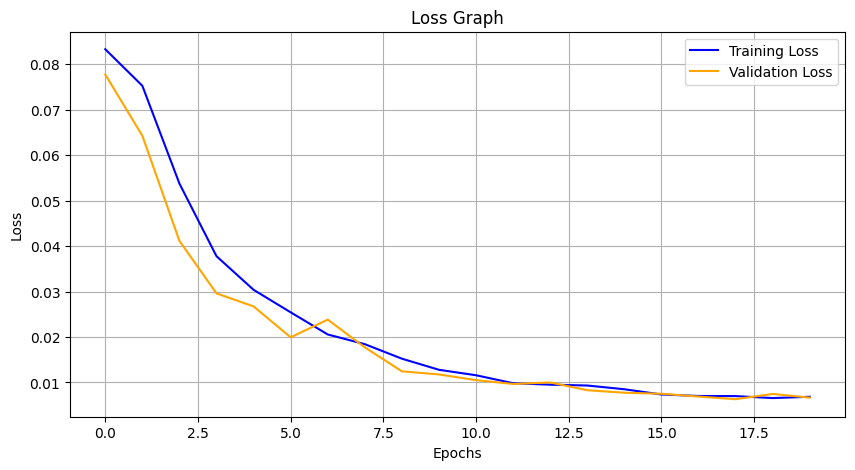

In [13]:
# --- Plot Loss Graph ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


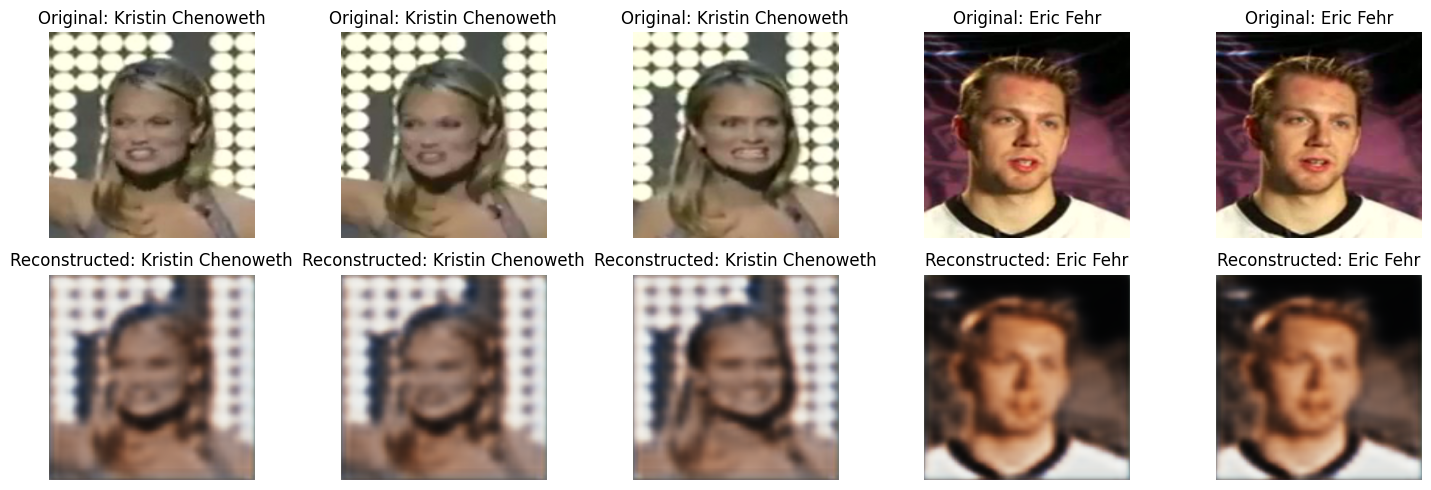

In [14]:
test_generator = DataGenerator(directory=dataset_dir, batch_size=16, file_sample_ratio=0.05, sample_ratio=0.05, img_size=(256, 256), shuffle=False, return_names=True)

# Test the generator to ensure it's working correctly and extract names for visualization
test_images, _, test_names = test_generator[0]  # First batch

# Generate enhanced images from the test set
reconstructed_images = autoencoder.predict(test_images[:5])  # Predicting on first 5 samples

# Display a comparison between original and enhanced images
display_comparison(test_images[:5], reconstructed_images, test_names, n=5)

In [15]:
# --- Create Predictions Table ---
predictions_df = pd.DataFrame({
    'Filename': test_generator.filenames[:5],
    'Original': [test_images[i] for i in range(5)],
    'Reconstructed': [reconstructed_images[i] for i in range(5)]
})

# Display predictions table
print(predictions_df)

            Filename                                           Original  \
0  Kristin Chenoweth  [[[0.3333333333333333, 0.3333333333333333, 0.2...   
1          Eric Fehr  [[[0.37254901960784315, 0.37254901960784315, 0...   
2       Paul Krueger  [[[1.0, 1.0, 0.8901960784313725], [1.0, 1.0, 0...   
3      Barbara Boxer  [[[0.09019607843137255, 0.023529411764705882, ...   
4    Francis Collins  [[[0.09411764705882353, 0.027450980392156862, ...   

                                       Reconstructed  
0  [[[0.4578448, 0.46177673, 0.474907], [0.441199...  
1  [[[0.45506015, 0.459606, 0.47317636], [0.43621...  
2  [[[0.47804746, 0.47794425, 0.48799297], [0.472...  
3  [[[0.40199533, 0.41596967, 0.4107213], [0.3423...  
4  [[[0.40294507, 0.41688058, 0.41194382], [0.343...  


In [16]:
# --- Calculate Performance Metrics ---
mse = mean_squared_error(test_images[:5].reshape(-1, 256 * 256 * 3), reconstructed_images.reshape(-1, 256 * 256 * 3)) 
psnr_value = psnr(test_images[:5], reconstructed_images, data_range=1.0)

# --- Create Performance Metrics Table ---
metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Peak Signal-to-Noise Ratio (PSNR)'],
    'Value': [mse, psnr_value]
})

# Display performance metrics table
print(metrics_df)

                              Metric      Value
0           Mean Squared Error (MSE)   0.009502
1  Peak Signal-to-Noise Ratio (PSNR)  20.222010


In [17]:
# Save the model after training
autoencoder.save("Facial-reconstruction-from-CCTV-footage/models/final_model-2.keras")

In [18]:
# Save comparisons for evaluation using person's name as filename
save_comparisons(test_images[:5], reconstructed_images, test_names)